In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from xdgmm import XDGMM

from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

from test_plots import *

import pandas as pd
'''
Due to AstroML still using the deprecated GMM class from 
scikit-learn (instead of GaussianMixture), this demo will 
throw numerous errors whenever the XDGMM object calls 
an AstroML method, such as fit. The lines below will 
suppress these warnings; comment them out to see everything.

This XDGMM class has been updated to use GaussianMixture 
instead of GMM when necessary, but since it uses an AstroML
XDGMM object to store and manipulate the model, it is 
dependent on AstroML. These warnings will continue to occur 
until the XDGMM class from AstroML has been updated.
'''
import warnings
warnings.filterwarnings('ignore')

Next, generate some data to use for our fitting and plotting.

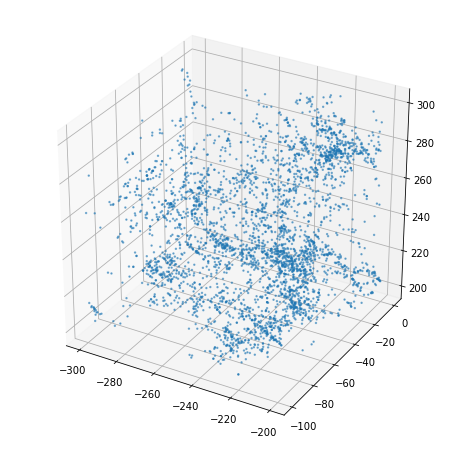

In [2]:
A=np.load("/Users/mahaixia/DATA/SDSS_DR7/galaxy_DR7/SDSS_box_bins100.npz")
data = A["a4"]
points=data[:,4:7]

# B=np.load("/Users/mahaixia/SDSS_GMM/SDSStest_radec.npz")
# radec_data = B['arr_0']
# radec_data = radec_data[0,:]
# np.savetxt("SDSStest_radec.txt", radec_data, fmt=' '.join(['%i'] + ['%1.5f']*3))

# data=np.loadtxt("/Users/mahaixia/DATA/SDSS_DR7/galaxy_DR7/SDSS7_tiny.txt")
# points=data[:,4:7]

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
# axes.set_zlim3d(200, 250)
# axes.set_xlim3d(-150, -100)
# axes.set_ylim3d(50, 100)
axes.scatter(points[:,0], points[:,1], points[:,2], s = 2.0, alpha = 0.5)

Xerr = np.zeros(points.shape + points.shape[-1:])
# Xerr[:,2,2] = 10
# Xerr[:,1,1] = 10
# Xerr[:,0,0] = 10

In [48]:
print(max(data[:,0]), min(data[:,0]))

487873.0 65277.0


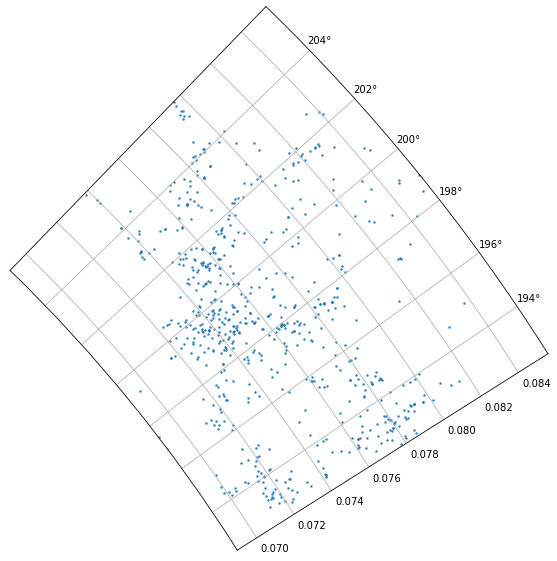

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='polar')
udeg = 0.017453293  #deg to rad
c = ax.scatter(data[:,1]*udeg, data[:,3], s=2.5, alpha=0.75)

ax.set_thetamax(np.max(data[:,1]))
ax.set_thetamin(np.min(data[:,1]))
ax.set_rorigin(-0)
ax.set_theta_zero_location('W', offset=20)
ax.set_rmax(np.max(data[:,3]))
ax.set_rmin(np.min(data[:,3]))

In [3]:
print("number of galaxies in total:", points.shape[0])

number of galaxies in total: 3574


In [5]:
def plot_sphere(center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], cov=[1,1,1], ax=None):
    '''
        plot a sphere surface
        Input:
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
                    是椭球的分辨率
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 30)   #np.linspace 取等差数列
    v = np.linspace(0, np.pi, 30)
    x = r[0] * np.outer(np.cos(u), np.sin(v))
    y = r[1] * np.outer(np.sin(u), np.sin(v))
    z = r[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    E = np.dstack((x, y, z))
    E = np.dot(E, rotation.T) + center
    x, y, z = np.rollaxis(E, axis=-1)

    ax.plot_surface(x, y, z, alpha=0.2, linewidth=0, antialiased=False)

    return ax

In [39]:
def find_fraction(points, center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], groupID=0):
    inner = 0.0
    outer = 0.0
    galaxy=[]
    midx = pd.DataFrame(columns=['GroupID','X','Y','Z'])
    x = points[:,0] - center[0]
    y = points[:,1] - center[1]
    z = points[:,2] - center[2]
    r = r   # 1 sigma球

    for j in range(len(x)):
        [x[j], y[j], z[j]] = np.dot([x[j], y[j], z[j]], rotation)
    for i in range(points.shape[0]):
        distance = np.square(x[i]/r[0]) + np.square(y[i]/r[1]) + np.square(z[i]/r[2])
        if distance > 5.0:
            outer +=1.0
        elif distance < 5.0:
            inner +=1.0
            galaxy.append(points[i])
    galaxy = np.array(galaxy)
    if not (len(galaxy)==0):
        Mgalaxy = pd.DataFrame({"GroupID":int(groupID)*np.ones(len(galaxy)), "X":galaxy[:,0], "Y":galaxy[:,1], "Z":galaxy[:,2]})
        midx=pd.concat([midx,Mgalaxy], axis=0, ignore_index="Ture")

    return inner, outer, midx

In [6]:
n_components= 78
import itertools
import matplotlib.cm as cmx

colors = cmx.Set1(np.linspace(0, 1, n_components))


In [7]:
def plot_sphere2D(center=[0,0,0], r=[1, 1, 1], rotation=[1,1,1], cov=[1,1,1], ax=None, color=[]):

    u = np.linspace(0, 2 * np.pi, 30)   #np.linspace 取等差数列
    v = np.linspace(0, np.pi, 30)
    x = r[0] * np.outer(np.cos(u), np.sin(v))
    y = r[1] * np.outer(np.sin(u), np.sin(v))
    z = r[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    E = np.dstack((x, y, z))
    E = np.dot(E, rotation.T) + center
    x, y, z = np.rollaxis(E, axis=-1)

    ax.plot(x, y, linewidth=0.8, alpha=0.3, color=color)

    return ax

In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components, covariance_type='full')
gmm.fit(points)

GaussianMixture(n_components=78)

In [9]:
membersk = pd.DataFrame(columns=['GroupID','X','Y','Z'])
Groupsk = pd.DataFrame(columns=['GroupID', 'N_members','X_center','Y_center','Z_center'])

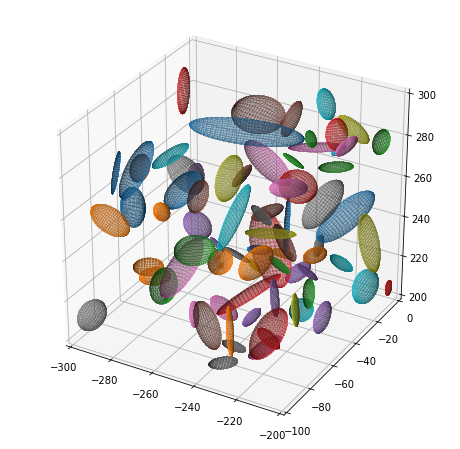

In [10]:
index = gmm.predict(points)
figsk = plt.figure(figsize=(8, 8))
axessk = figsk.add_subplot(111, projection='3d')
axessk.set_zlim3d(200, 300)
axessk.set_xlim3d(-300, -200)
axessk.set_ylim3d(-100, 0)

for i in range(n_components):
    covariances = gmm.covariances_[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    mean = gmm.means_[i,:3]
    group = points[np.where(index == i)]
    plot_sphere(mean, r, u, ax=axessk)
    inner, outer, mlist = find_fraction(data, center=mean, r=r, rotation=u, groupID=i)
    membersk=pd.concat([membersk,mlist], axis=0, ignore_index="Ture")
    group_ifo = pd.DataFrame({'GroupID':int(i), 'N_members':inner,'X_center':mean[0],'Y_center':mean[1],'Z_center':mean[2]}, index=[0])
    Groupsk=pd.concat([Groupsk,group_ifo], axis=0, ignore_index="Ture")
X=mlist["X"]
Y=mlist["Y"]
Z=mlist["Z"]
axessk.scatter(X, Y, Z, s=5)

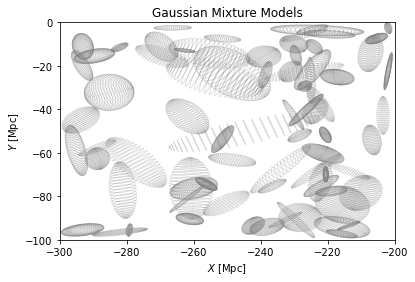

In [11]:
index = gmm.predict(points)
axes = plt.subplot()

for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):
    if not np.any(index == i):
            continue
    covariances = gmm.covariances_[i][:3, :3]
    v, u = np.linalg.eigh(covar)
    r = np.sqrt(v)
    plot_sphere2D(mean, r, u, ax=axes, color="gray")

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.xlabel("$X$ [Mpc]")
plt.ylabel("$Y$ [Mpc]")
plt.xlim(-300, -200)
plt.ylim(-100, 0)
axes.set_title("Gaussian Mixture Models")
X=membersk["X"]
Y=membersk["Y"]
plt.scatter(X, Y, 1.0)

## Component Number Selection

We could fit this data directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way this can be determined is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

In [13]:
# Instantiate an XDGMM model:
xdgmm = XDGMM(method='Bovy', )

In [16]:
# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.arange(2, 18, 1)

# Loop over component numbers, fitting XDGMM model and computing the BIC:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(points, Xerr, param_range, no_err=True)

N = 2 , BIC = 100864.56338135293


KeyboardInterrupt: 

In [70]:
plot_bic(param_range, bic, optimal_n_comp)

NameError: name 'param_range' is not defined

## Model Fitting

Now that we know the best number of components to use, we can fit the data. First set the number of components, then perform the fit.

In [14]:
# xdgmm.n_components = optimal_n_comp
xdgmm.n_components = 78
xdgmm = xdgmm.fit(points, Xerr)
print("xdgmm fitting: done!")

index = xdgmm.predict(points, Xerr)

xdgmm fitting: done!


In [15]:
memberxd = pd.DataFrame(columns=['GroupID','X','Y','Z'])
Groupxd = pd.DataFrame(columns=['GroupID', 'N_members','X_center','Y_center','Z_center'])

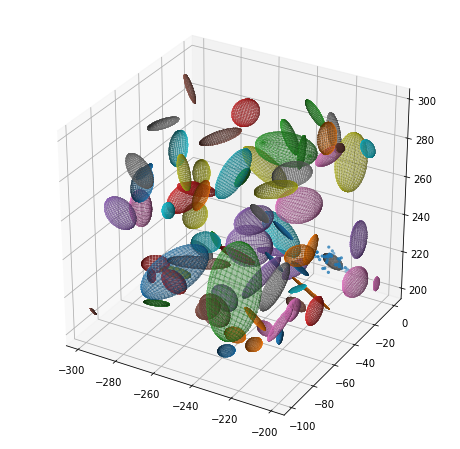

In [43]:
figxd = plt.figure(figsize=(8, 8))
axesxd = figxd.add_subplot(111, projection='3d')

for i in range(xdgmm.n_components):
    covariances = xdgmm.V[i][:3, :3]
    v, u = np.linalg.eigh(covariances)
    r = np.sqrt(v)
    mean = xdgmm.mu[i,:3]
    group = points[np.where(index == i)]
    inner, outer, mlist = find_fraction(group, center=mean, r=r, rotation=u, groupID=i)
    if (inner>1):
    # if ((np.max(r)<15)&(inner>1)):
        plot_sphere(mean, r, u, ax=axesxd)
        memberxd=pd.concat([memberxd,mlist], axis=0, ignore_index="Ture")
    group_ifo = pd.DataFrame({'GroupID':int(i), 'N_members':int(inner),'X_center':mean[0],'Y_center':mean[1],'Z_center':mean[2]}, index=[0])
    Groupxd=pd.concat([Groupxd,group_ifo], axis=0, ignore_index="Ture")
X=mlist["X"]
Y=mlist["Y"]
Z=mlist["Z"]
axesxd.scatter(X, Y, Z, s=5)

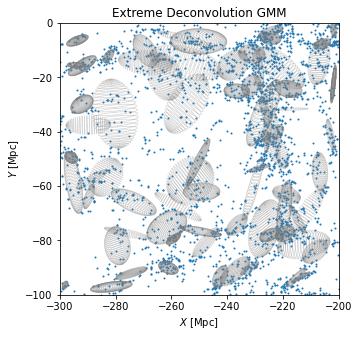

In [20]:
axes = plt.subplot()
# colorxd = cmx.Set1(np.linspace(0, 1, xdgmm.n_components))

for i, (mean, covar) in enumerate(zip(xdgmm.mu, xdgmm.V)):
    if not np.any(index == i):
            continue
    covariances = xdgmm.V[i][:3, :3]
    v, u = np.linalg.eigh(covar)
    r = np.sqrt(v)
    if ((np.max(r)<15)&(Groupxd["N_members"][i]>1)):
        plot_sphere2D(mean, r, u, ax=axes, color="gray")

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.xlabel("$X$ [Mpc]")
plt.ylabel("$Y$ [Mpc]")
plt.xlim(-300, -200)
plt.ylim(-100, 0)
axes.set_title("Extreme Deconvolution GMM")
X=memberxd["X"]
Y=memberxd["Y"]
plt.scatter(X, Y, 1.0)

In [41]:
memberxd["GroupID"].astype(int)
print(memberxd)
memberxd.to_csv('Member_box_bins100x.csv', index=False)

      GroupID           X          Y           Z
0         0.0 -227.754816 -52.126512  233.751061
1         0.0 -227.660111 -52.347271  234.632196
2         0.0 -227.675814 -52.411866  234.602537
3         0.0 -226.728051 -52.220050  233.622923
4         0.0 -230.262090 -53.012857  236.677080
...       ...         ...        ...         ...
6001     77.0 -227.846273  -1.220547  216.758340
6002     77.0 -222.769376  -1.275283  211.835706
6003     77.0 -221.496964  -2.934302  210.246589
6004     77.0 -225.984860  -3.914154  214.786728
6005     77.0 -224.882576  -4.037737  214.051342

[6006 rows x 4 columns]


In [46]:
Groupxd["GroupID"].astype(int)
print(Groupxd)
Groupxd.to_csv('Group_box_bins100.csv', index=False)

    GroupID  N_members    X_center   Y_center    Z_center
0         0       31.0 -228.383301 -53.332519  234.844982
1         1       57.0 -218.029077 -24.292830  287.698095
2         2       41.0 -282.554551 -12.210844  210.143316
3         3       31.0 -261.617383 -75.206736  269.349861
4         4       67.0 -237.882101 -15.557804  208.996396
..      ...        ...         ...        ...         ...
229      73       23.0 -295.856511 -49.460930  205.163552
230      74       38.0 -249.154405 -62.089885  213.857483
231      75       40.0 -272.806772 -45.050147  217.182144
232      76       78.0 -219.310607 -77.497440  215.073913
233      77       44.0 -224.379312  -3.279867  210.801919

[234 rows x 5 columns]
